[![Open In Colab](https://colab.research.google.com/assets/colab-badge.svg)](https://colab.research.google.com/github/mravanba/comp451/blob/master/Optimization.ipynb)

# Optimization
In this notebook we see examples of first order and second order methods applied to the optimization of a simple function with 2D input. We then see how we can use a similar approach in fitting a model in machine learning.

Consider the following non-convex function, called *Rosenbrock* function: $$\mathcal{L}(x) = (1 - x_1)^2 + 100 (x_2 - x_1^2)^2$$ Its minimum is at $x = [1,1]$. Below first we define a helper function `plot_contour` for plotting functions with 2D input. We then use this function to plot the Rosenbrock function.

In [64]:
import numpy as np
#%matplotlib notebook
%matplotlib inline
import matplotlib.pyplot as plt
from IPython.core.debugger import set_trace
import warnings
warnings.filterwarnings('ignore')

In [65]:
import itertools
def plot_contour(f, x1bound, x2bound, resolution, ax):
    x1range = np.linspace(x1bound[0], x1bound[1], resolution)
    x2range = np.linspace(x2bound[0], x2bound[1], resolution)
    xg, yg = np.meshgrid(x1range, x2range)
    zg = np.zeros_like(xg)
    for i,j in itertools.product(range(resolution), range(resolution)):
        zg[i,j] = f([xg[i,j], yg[i,j]])
    ax.contour(xg, yg, zg, 100)
    return ax

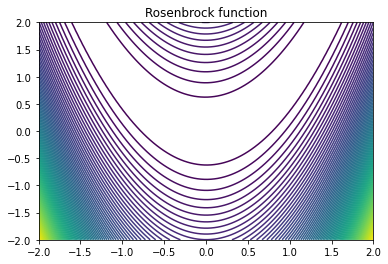

In [66]:
L = lambda x: (1 - x[0])**2  + 100*(x[1] - x[0]**2)**2
ax = plt.gca()
plot_contour(L, [-2,2], [-2,2], 100, ax)
ax.set_title("Rosenbrock function")
plt.show()

## Gradient descent vs. Newton method
First order methods use information about the first derivative of the objective function. In particular gradient descent or steepest descent simply moves in the oposite direction of the derivative. 
For the function above, the gradient is 
$$\nabla \mathcal{L}(x) = [-2(1-x_1) - 400 x_1(x_2 - x_1^2),  200(x_2 - x_1^2)]$$

### Checking the gradient calculation
Here, we have calculated the gradient *analytically*. To make sure our gradient calculation is correct, it is always a good idea to check that against finite difference approximation at some points on its domain. The smalle value returned by `check_grad` is reassuring, since it is the 2-norm of the different between numerical and analytical gradient.

In [67]:
from scipy import optimize
dL = lambda x: np.array([-2*(1. - x[0]) - 400*x[0]*(x[1] - x[0]**2), 200*(x[1] - x[0]**2)])
optimize.check_grad(L, dL, [1,1])

6.158363551077384e-06

### Comparison
We then proceed to calculate the Hessian matrix, used by the Newton method:
$$
\nabla^2 \mathcal{L}(x) = \begin{bmatrix} 2 + 800 x_1 - 400 x_2 & - 400 x_1 \\ - 400 x_1 & 200 \end{bmatrix}
$$
We see that the matrix is symmetric and positive definite. Again, we can check Hessian against 

Below we implement simple versions of both gradient descent and the Newton method, and compare their performance. 

In [116]:
def gradient_descent(dL, x0, step_size=.001, max_steps=100):
    x = x0
    x_rec = np.zeros((max_steps+1,) + x0.shape) #records the progress of the Newton method for visualization purposes
    x_rec[0] = x0
    for step in range(max_steps):
        x = x - step_size * dL(x)
        x_rec[step+1] = x
    return x_rec

ddL = lambda x: np.array([[2 + 800*x[0] - 400 * x[1], -400*x[0]],[-400*x[0], 200]]) #Hessian for Rosenbrock function
def newton_method(dL, ddL, x0, max_steps=100):
    x = x0
    x_rec = np.zeros((max_steps+1,) + x0.shape) #records the progress of the Newton method for visualization purposes
    x_rec[0] = x0
    for step in range(max_steps):
        H = ddL(x) #Hessian
        g = dL(x) #gradient
        x = x - np.linalg.solve(H, g) #equivalent to np.linalg.inv(H) @ g  
        x_rec[step+1] = x
    return x_rec

Below we see that Newton method converges within 2 steps, while gradient descent does not converge even after 1000 steps.

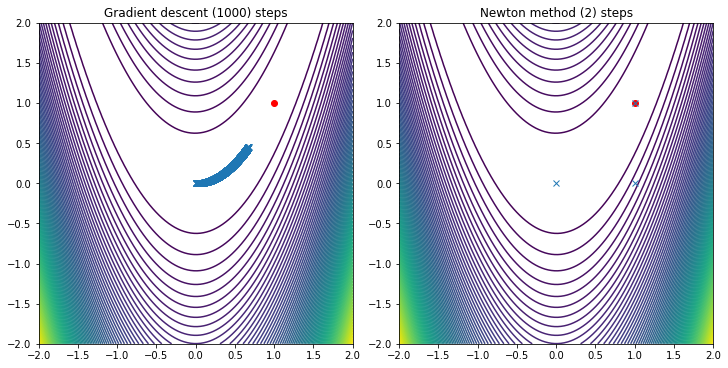

In [117]:
fig, axes = plt.subplots(ncols=2, nrows=1, constrained_layout=True, figsize=(10, 5))
plot_contour(L, [-2,2], [-2,2], 100, axes[0])
plot_contour(L, [-2,2], [-2,2], 100, axes[1])
x0 = np.array([0,0]) #starting point
gd_rec = gradient_descent(dL, x0, max_steps = 1000)
nt_rec = newton_method(dL, ddL, x0, max_steps = 2)
axes[0].plot([1],[1], 'ro')
axes[1].plot([1],[1], 'ro')
axes[0].plot(gd_rec[:,0], gd_rec[:,1], 'x')
axes[1].plot(nt_rec[:,0], nt_rec[:,1], 'x')
axes[0].set_title("Gradient descent (1000) steps")
axes[1].set_title("Newton method (2) steps")
plt.show()

## Optimization for fitting a model
Given we can calculate the gradient of our cost function, we can minimize it by moving in the opposite direction of the gradient using some learning rate. In this notebook, we want to try different Gradient Descent methods, by implementing them independently of the underlying model. This way we can simply pass a `gradient()` function to the **optimizer** and ask it to find the optimal set of parameters for our model -- that is we don't need a specialized implementation say for `LinearRegression`, or `LogisticRegression` that we see next. While there are different ways we could have a separate optimizer, here, we define an optimizer class -- such as `StochasticGradientDescent` -- and pass an instance of this class to the `fit` function for our model. The `fit` function could then `run` the optimizer to fit the data. Here, we only implement the vanilla `GradientDescent` class.

In [2]:
class GradientDescent:
    
    def __init__(self, learning_rate=.001, max_iters=1e4, epsilon=1e-8, record_history=False):
        self.learning_rate = learning_rate
        self.max_iters = max_iters
        self.record_history = record_history
        self.epsilon = epsilon
        if record_history:
            self.w_history = []                 #to store the weight history for visualization
            
    def run(self, gradient_fn, x, y, w):
        grad = np.inf
        t = 1
        while np.linalg.norm(grad) > self.epsilon and t < self.max_iters:
            grad = gradient_fn(x, y, w)               # compute the gradient with present weight
            w = w - self.learning_rate * grad         # weight update step
            if self.record_history:
                self.w_history.append(w)
            t += 1
        return w

Note that in the implementation above we added an option to record the history of model parameter's during gradient descent for the purpose of visualization.
Let's reimplement the `LinearRegression` class to use an optimizer.

In [3]:
class LinearRegression:
    def __init__(self, add_bias=True):
        self.add_bias = add_bias
        pass
            
    def fit(self, x, y, optimizer):
        if x.ndim == 1:
            x = x[:, None]
        if self.add_bias:
            N = x.shape[0]
            x = np.column_stack([x,np.ones(N)])
        N,D = x.shape
        def gradient(x, y, w):                          # define the gradient function
            yh =  x @ w 
            N, D = x.shape
            grad = .5*np.dot(yh - y, x)/N
            return grad
        w0 = np.zeros(D)                                # initialize the weights to 0
        self.w = optimizer.run(gradient, x, y, w0)      # run the optimizer to get the optimal weights
        return self
    
    def predict(self, x):
        if self.add_bias:
            x = np.column_stack([x,np.ones(N)])
        yh = x@self.w
        return yh

Now let's fit this model to to the toy data we saw in the linear regression notebook.

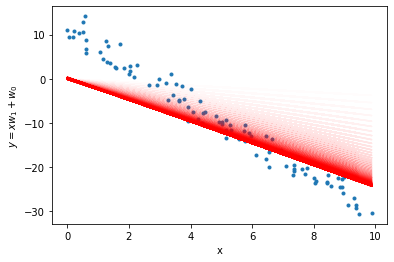

In [4]:
N = 100
x = np.random.rand(N) * 10
y = -4*x + 10 + 2*np.random.randn(N)
optimizer = GradientDescent(learning_rate=.005, max_iters=100, record_history=True)
model = LinearRegression()
model.fit(x,y, optimizer)
plt.plot(x, y, '.')
for t,w in enumerate(optimizer.w_history):
    plt.plot(x, x*w[0]+w[1], 'r-', alpha=t/len(optimizer.w_history), label=str(t))
plt.xlabel('x')
plt.ylabel(r'$y=xw_1 + w_0$')
#plt.xlim(-20,20)
#plt.ylim(-100,100)
plt.show()

### Effect of the learning rate
Next, let's visualize the effect of learning rate on the behaviour of gradient descent in linear regression.
Again, we use the plot-contour function to visualize the optimization landscape. 

Let's track the steps of the 
gradient descent using different values for the learning rate.

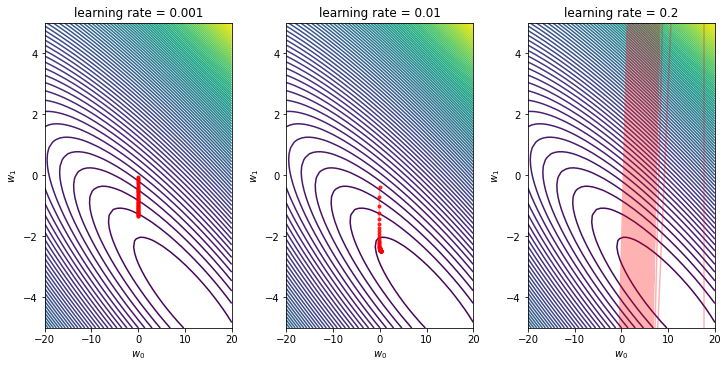

In [6]:
cost = lambda w: .5*np.mean((w[0] + w[1]*x - y)**2)
learning_rates = [.001, .01, .2]
fig, axes = plt.subplots(ncols=len(learning_rates), nrows=1, constrained_layout=True, figsize=(10, 5))
for i, lr in enumerate(learning_rates):
    optimizer = GradientDescent(learning_rate=lr, max_iters=50, record_history=True)
    model = LinearRegression()
    model.fit(x,y, optimizer)
    plot_contour(cost, [-20,20], [-5,5], 50, axes[i])
    w_hist = np.vstack(optimizer.w_history)                  # get the history for plotting
    axes[i].plot(w_hist[:,1], w_hist[:,0], '.r', alpha=.8)
    axes[i].plot(w_hist[:,1], w_hist[:,0], '-r', alpha=.3)
    axes[i].set_xlabel(r'$w_0$')
    axes[i].set_ylabel(r'$w_1$')
    axes[i].set_title(f'learning rate = {lr}')
    axes[i].set_xlim([-20,20])
    axes[i].set_ylim([-5,5])
plt.show()